# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 4000            

# --- Dataset configuration ---
base_data_size = 60      
dataset_type = "data"   
dataset_quantities = [0, 600-60, 2000 - 60, 6000 - 60, 20000 - 60, 60000 - 60]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import MNIST_model_data as model_module

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device = device
)

# MNIST specific initialization parameters
hidden_dims = [256, 128]

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/4000: Train Loss 2.3023 | Test Loss 2.2335 | accs Train 0.0833 Test 0.1997


Epoch 100/4000: Train Loss 0.0001 | Test Loss 1.6001 | accs Train 1.0000 Test 0.6530


Epoch 200/4000: Train Loss 0.0001 | Test Loss 1.6089 | accs Train 1.0000 Test 0.6536


Epoch 300/4000: Train Loss 0.0000 | Test Loss 1.6205 | accs Train 1.0000 Test 0.6542


Epoch 400/4000: Train Loss 0.0000 | Test Loss 1.6333 | accs Train 1.0000 Test 0.6543


Epoch 500/4000: Train Loss 0.0000 | Test Loss 1.6458 | accs Train 1.0000 Test 0.6553


Epoch 600/4000: Train Loss 0.0000 | Test Loss 1.6575 | accs Train 1.0000 Test 0.6554


Epoch 700/4000: Train Loss 0.0000 | Test Loss 1.6680 | accs Train 1.0000 Test 0.6557


Epoch 800/4000: Train Loss 0.0000 | Test Loss 1.6782 | accs Train 1.0000 Test 0.6555


Epoch 900/4000: Train Loss 0.0000 | Test Loss 1.6879 | accs Train 1.0000 Test 0.6557


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 1.6967 | accs Train 1.0000 Test 0.6564


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 1.7050 | accs Train 1.0000 Test 0.6567


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 1.7127 | accs Train 1.0000 Test 0.6577


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 1.7203 | accs Train 1.0000 Test 0.6580


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 1.7274 | accs Train 1.0000 Test 0.6577


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 1.7340 | accs Train 1.0000 Test 0.6581


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 1.7405 | accs Train 1.0000 Test 0.6580


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 1.7466 | accs Train 1.0000 Test 0.6582


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 1.7525 | accs Train 1.0000 Test 0.6589


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 1.7582 | accs Train 1.0000 Test 0.6589


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 1.7635 | accs Train 1.0000 Test 0.6592


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 1.7689 | accs Train 1.0000 Test 0.6593


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 1.7744 | accs Train 1.0000 Test 0.6595


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 1.7801 | accs Train 1.0000 Test 0.6596


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 1.7856 | accs Train 1.0000 Test 0.6600


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 1.7908 | accs Train 1.0000 Test 0.6604


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 1.7960 | accs Train 1.0000 Test 0.6608


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 1.8010 | accs Train 1.0000 Test 0.6608


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 1.8061 | accs Train 1.0000 Test 0.6604


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 1.8111 | accs Train 1.0000 Test 0.6605


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 1.8160 | accs Train 1.0000 Test 0.6608


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 1.8210 | accs Train 1.0000 Test 0.6611


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 1.8261 | accs Train 1.0000 Test 0.6612


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 1.8312 | accs Train 1.0000 Test 0.6607


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 1.8360 | accs Train 1.0000 Test 0.6608


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 1.8412 | accs Train 1.0000 Test 0.6605


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 1.8464 | accs Train 1.0000 Test 0.6604


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 1.8514 | accs Train 1.0000 Test 0.6609


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 1.8563 | accs Train 1.0000 Test 0.6606


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 1.8620 | accs Train 1.0000 Test 0.6605


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 1.8667 | accs Train 1.0000 Test 0.6604
Completed training with 0 additional samples of data
Epoch 1/4000: Train Loss 2.3046 | Test Loss 2.1923 | accs Train 0.0733 Test 0.3176


Epoch 100/4000: Train Loss 0.0014 | Test Loss 0.6743 | accs Train 1.0000 Test 0.8671


Epoch 200/4000: Train Loss 0.0005 | Test Loss 0.7203 | accs Train 1.0000 Test 0.8681


Epoch 300/4000: Train Loss 0.0003 | Test Loss 0.7505 | accs Train 1.0000 Test 0.8689


Epoch 400/4000: Train Loss 0.0002 | Test Loss 0.7730 | accs Train 1.0000 Test 0.8698


Epoch 500/4000: Train Loss 0.0001 | Test Loss 0.7908 | accs Train 1.0000 Test 0.8701


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.8056 | accs Train 1.0000 Test 0.8704


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.8183 | accs Train 1.0000 Test 0.8708


Epoch 800/4000: Train Loss 0.0000 | Test Loss 0.8292 | accs Train 1.0000 Test 0.8711


Epoch 900/4000: Train Loss 0.0000 | Test Loss 0.8388 | accs Train 1.0000 Test 0.8720


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 0.8473 | accs Train 1.0000 Test 0.8725


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.8551 | accs Train 1.0000 Test 0.8725


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.8622 | accs Train 1.0000 Test 0.8725


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.8687 | accs Train 1.0000 Test 0.8726


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.8747 | accs Train 1.0000 Test 0.8728


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.8802 | accs Train 1.0000 Test 0.8728


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.8855 | accs Train 1.0000 Test 0.8731


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.8904 | accs Train 1.0000 Test 0.8732


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.8950 | accs Train 1.0000 Test 0.8737


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.8993 | accs Train 1.0000 Test 0.8737


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.9034 | accs Train 1.0000 Test 0.8736


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.9073 | accs Train 1.0000 Test 0.8736


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.9111 | accs Train 1.0000 Test 0.8737


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.9147 | accs Train 1.0000 Test 0.8737


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.9182 | accs Train 1.0000 Test 0.8735


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.9215 | accs Train 1.0000 Test 0.8734


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.9248 | accs Train 1.0000 Test 0.8738


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.9279 | accs Train 1.0000 Test 0.8741


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.9310 | accs Train 1.0000 Test 0.8741


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.9341 | accs Train 1.0000 Test 0.8741


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.9371 | accs Train 1.0000 Test 0.8743


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.9399 | accs Train 1.0000 Test 0.8744


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.9427 | accs Train 1.0000 Test 0.8743


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.9456 | accs Train 1.0000 Test 0.8742


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.9483 | accs Train 1.0000 Test 0.8744


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.9509 | accs Train 1.0000 Test 0.8746


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.9535 | accs Train 1.0000 Test 0.8748


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.9561 | accs Train 1.0000 Test 0.8751


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.9586 | accs Train 1.0000 Test 0.8753


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.9611 | accs Train 1.0000 Test 0.8754


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.9636 | accs Train 1.0000 Test 0.8758
Completed training with 540 additional samples of data
Epoch 1/4000: Train Loss 2.3081 | Test Loss 2.1816 | accs Train 0.0720 Test 0.3391


Epoch 100/4000: Train Loss 0.0056 | Test Loss 0.4396 | accs Train 1.0000 Test 0.9050


Epoch 200/4000: Train Loss 0.0009 | Test Loss 0.4942 | accs Train 1.0000 Test 0.9071


Epoch 300/4000: Train Loss 0.0004 | Test Loss 0.5213 | accs Train 1.0000 Test 0.9088


Epoch 400/4000: Train Loss 0.0002 | Test Loss 0.5398 | accs Train 1.0000 Test 0.9109


Epoch 500/4000: Train Loss 0.0001 | Test Loss 0.5538 | accs Train 1.0000 Test 0.9119


Epoch 600/4000: Train Loss 0.0001 | Test Loss 0.5651 | accs Train 1.0000 Test 0.9121


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.5746 | accs Train 1.0000 Test 0.9121


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.5830 | accs Train 1.0000 Test 0.9127


Epoch 900/4000: Train Loss 0.0000 | Test Loss 0.5903 | accs Train 1.0000 Test 0.9128


Epoch 1000/4000: Train Loss 0.0000 | Test Loss 0.5969 | accs Train 1.0000 Test 0.9129


Epoch 1100/4000: Train Loss 0.0000 | Test Loss 0.6028 | accs Train 1.0000 Test 0.9127


Epoch 1200/4000: Train Loss 0.0000 | Test Loss 0.6083 | accs Train 1.0000 Test 0.9129


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.6134 | accs Train 1.0000 Test 0.9130


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.6181 | accs Train 1.0000 Test 0.9133


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.6225 | accs Train 1.0000 Test 0.9132


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.6266 | accs Train 1.0000 Test 0.9135


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.6305 | accs Train 1.0000 Test 0.9137


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.6342 | accs Train 1.0000 Test 0.9136


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.6377 | accs Train 1.0000 Test 0.9136


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.6410 | accs Train 1.0000 Test 0.9138


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.6442 | accs Train 1.0000 Test 0.9138


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.6472 | accs Train 1.0000 Test 0.9138


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.6502 | accs Train 1.0000 Test 0.9140


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.6530 | accs Train 1.0000 Test 0.9141


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.6557 | accs Train 1.0000 Test 0.9142


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.6584 | accs Train 1.0000 Test 0.9145


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.6610 | accs Train 1.0000 Test 0.9145


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.6634 | accs Train 1.0000 Test 0.9145


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.6659 | accs Train 1.0000 Test 0.9145


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.6683 | accs Train 1.0000 Test 0.9148


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.6706 | accs Train 1.0000 Test 0.9147


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.6729 | accs Train 1.0000 Test 0.9149


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.6752 | accs Train 1.0000 Test 0.9149


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.6774 | accs Train 1.0000 Test 0.9150


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.6796 | accs Train 1.0000 Test 0.9148


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.6817 | accs Train 1.0000 Test 0.9145


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.6838 | accs Train 1.0000 Test 0.9145


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.6859 | accs Train 1.0000 Test 0.9146


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.6879 | accs Train 1.0000 Test 0.9145


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.6900 | accs Train 1.0000 Test 0.9144
Completed training with 1940 additional samples of data
Epoch 1/4000: Train Loss 2.3138 | Test Loss 2.1808 | accs Train 0.0735 Test 0.4319


Epoch 100/4000: Train Loss 0.0344 | Test Loss 0.2344 | accs Train 0.9958 Test 0.9368


Epoch 200/4000: Train Loss 0.0024 | Test Loss 0.2707 | accs Train 1.0000 Test 0.9419


Epoch 300/4000: Train Loss 0.0009 | Test Loss 0.2934 | accs Train 1.0000 Test 0.9430


Epoch 400/4000: Train Loss 0.0005 | Test Loss 0.3084 | accs Train 1.0000 Test 0.9434


Epoch 500/4000: Train Loss 0.0003 | Test Loss 0.3196 | accs Train 1.0000 Test 0.9437


Epoch 600/4000: Train Loss 0.0002 | Test Loss 0.3289 | accs Train 1.0000 Test 0.9433


Epoch 700/4000: Train Loss 0.0001 | Test Loss 0.3368 | accs Train 1.0000 Test 0.9434


Epoch 800/4000: Train Loss 0.0001 | Test Loss 0.3435 | accs Train 1.0000 Test 0.9433


Epoch 900/4000: Train Loss 0.0001 | Test Loss 0.3495 | accs Train 1.0000 Test 0.9432


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.3548 | accs Train 1.0000 Test 0.9432


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.3595 | accs Train 1.0000 Test 0.9431


Epoch 1200/4000: Train Loss 0.0001 | Test Loss 0.3638 | accs Train 1.0000 Test 0.9432


Epoch 1300/4000: Train Loss 0.0000 | Test Loss 0.3678 | accs Train 1.0000 Test 0.9432


Epoch 1400/4000: Train Loss 0.0000 | Test Loss 0.3714 | accs Train 1.0000 Test 0.9436


Epoch 1500/4000: Train Loss 0.0000 | Test Loss 0.3748 | accs Train 1.0000 Test 0.9435


Epoch 1600/4000: Train Loss 0.0000 | Test Loss 0.3779 | accs Train 1.0000 Test 0.9434


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.3809 | accs Train 1.0000 Test 0.9433


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.3836 | accs Train 1.0000 Test 0.9433


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.3862 | accs Train 1.0000 Test 0.9432


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.3888 | accs Train 1.0000 Test 0.9432


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.3912 | accs Train 1.0000 Test 0.9434


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.3935 | accs Train 1.0000 Test 0.9435


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.3957 | accs Train 1.0000 Test 0.9436


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.3979 | accs Train 1.0000 Test 0.9436


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.3999 | accs Train 1.0000 Test 0.9438


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.4020 | accs Train 1.0000 Test 0.9439


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.4039 | accs Train 1.0000 Test 0.9438


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.4059 | accs Train 1.0000 Test 0.9437


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.4078 | accs Train 1.0000 Test 0.9436


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.4096 | accs Train 1.0000 Test 0.9439


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.4115 | accs Train 1.0000 Test 0.9440


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.4133 | accs Train 1.0000 Test 0.9442


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.4151 | accs Train 1.0000 Test 0.9444


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.4169 | accs Train 1.0000 Test 0.9445


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.4186 | accs Train 1.0000 Test 0.9448


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.4203 | accs Train 1.0000 Test 0.9449


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.4219 | accs Train 1.0000 Test 0.9449


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.4235 | accs Train 1.0000 Test 0.9451


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.4251 | accs Train 1.0000 Test 0.9451


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.4267 | accs Train 1.0000 Test 0.9450
Completed training with 5940 additional samples of data
Epoch 1/4000: Train Loss 2.3138 | Test Loss 2.1813 | accs Train 0.0768 Test 0.4090


Epoch 100/4000: Train Loss 0.0953 | Test Loss 0.1476 | accs Train 0.9752 Test 0.9562


Epoch 200/4000: Train Loss 0.0133 | Test Loss 0.1349 | accs Train 0.9991 Test 0.9642


Epoch 300/4000: Train Loss 0.0029 | Test Loss 0.1519 | accs Train 1.0000 Test 0.9657


Epoch 400/4000: Train Loss 0.0013 | Test Loss 0.1640 | accs Train 1.0000 Test 0.9658


Epoch 500/4000: Train Loss 0.0007 | Test Loss 0.1730 | accs Train 1.0000 Test 0.9660


Epoch 600/4000: Train Loss 0.0005 | Test Loss 0.1802 | accs Train 1.0000 Test 0.9665


Epoch 700/4000: Train Loss 0.0003 | Test Loss 0.1862 | accs Train 1.0000 Test 0.9666


Epoch 800/4000: Train Loss 0.0002 | Test Loss 0.1913 | accs Train 1.0000 Test 0.9667


Epoch 900/4000: Train Loss 0.0002 | Test Loss 0.1957 | accs Train 1.0000 Test 0.9666


Epoch 1000/4000: Train Loss 0.0001 | Test Loss 0.1997 | accs Train 1.0000 Test 0.9661


Epoch 1100/4000: Train Loss 0.0001 | Test Loss 0.2033 | accs Train 1.0000 Test 0.9660


Epoch 1200/4000: Train Loss 0.0001 | Test Loss 0.2065 | accs Train 1.0000 Test 0.9658


Epoch 1300/4000: Train Loss 0.0001 | Test Loss 0.2095 | accs Train 1.0000 Test 0.9661


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.2122 | accs Train 1.0000 Test 0.9661


Epoch 1500/4000: Train Loss 0.0001 | Test Loss 0.2148 | accs Train 1.0000 Test 0.9661


Epoch 1600/4000: Train Loss 0.0001 | Test Loss 0.2172 | accs Train 1.0000 Test 0.9661


Epoch 1700/4000: Train Loss 0.0000 | Test Loss 0.2194 | accs Train 1.0000 Test 0.9663


Epoch 1800/4000: Train Loss 0.0000 | Test Loss 0.2215 | accs Train 1.0000 Test 0.9663


Epoch 1900/4000: Train Loss 0.0000 | Test Loss 0.2236 | accs Train 1.0000 Test 0.9664


Epoch 2000/4000: Train Loss 0.0000 | Test Loss 0.2255 | accs Train 1.0000 Test 0.9665


Epoch 2100/4000: Train Loss 0.0000 | Test Loss 0.2273 | accs Train 1.0000 Test 0.9664


Epoch 2200/4000: Train Loss 0.0000 | Test Loss 0.2291 | accs Train 1.0000 Test 0.9663


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.2308 | accs Train 1.0000 Test 0.9664


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.2325 | accs Train 1.0000 Test 0.9664


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.2341 | accs Train 1.0000 Test 0.9664


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.2357 | accs Train 1.0000 Test 0.9665


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.2373 | accs Train 1.0000 Test 0.9665


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.2388 | accs Train 1.0000 Test 0.9666


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.2403 | accs Train 1.0000 Test 0.9666


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.2417 | accs Train 1.0000 Test 0.9666


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.2431 | accs Train 1.0000 Test 0.9665


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.2445 | accs Train 1.0000 Test 0.9666


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.2458 | accs Train 1.0000 Test 0.9666


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.2472 | accs Train 1.0000 Test 0.9666


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.2485 | accs Train 1.0000 Test 0.9664


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.2498 | accs Train 1.0000 Test 0.9664


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.2511 | accs Train 1.0000 Test 0.9664


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.2523 | accs Train 1.0000 Test 0.9665


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.2536 | accs Train 1.0000 Test 0.9666


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.2549 | accs Train 1.0000 Test 0.9666
Completed training with 19940 additional samples of data
Epoch 1/4000: Train Loss 2.3137 | Test Loss 2.1815 | accs Train 0.0759 Test 0.4039


Epoch 100/4000: Train Loss 0.1190 | Test Loss 0.1314 | accs Train 0.9667 Test 0.9610


Epoch 200/4000: Train Loss 0.0411 | Test Loss 0.0896 | accs Train 0.9898 Test 0.9734


Epoch 300/4000: Train Loss 0.0133 | Test Loss 0.0880 | accs Train 0.9982 Test 0.9758


Epoch 400/4000: Train Loss 0.0046 | Test Loss 0.0989 | accs Train 0.9999 Test 0.9758


Epoch 500/4000: Train Loss 0.0021 | Test Loss 0.1079 | accs Train 1.0000 Test 0.9756


Epoch 600/4000: Train Loss 0.0012 | Test Loss 0.1152 | accs Train 1.0000 Test 0.9762


Epoch 700/4000: Train Loss 0.0008 | Test Loss 0.1211 | accs Train 1.0000 Test 0.9764


Epoch 800/4000: Train Loss 0.0006 | Test Loss 0.1259 | accs Train 1.0000 Test 0.9764


Epoch 900/4000: Train Loss 0.0004 | Test Loss 0.1301 | accs Train 1.0000 Test 0.9763


Epoch 1000/4000: Train Loss 0.0003 | Test Loss 0.1337 | accs Train 1.0000 Test 0.9764


Epoch 1100/4000: Train Loss 0.0003 | Test Loss 0.1370 | accs Train 1.0000 Test 0.9764


Epoch 1200/4000: Train Loss 0.0002 | Test Loss 0.1399 | accs Train 1.0000 Test 0.9763


Epoch 1300/4000: Train Loss 0.0002 | Test Loss 0.1425 | accs Train 1.0000 Test 0.9761


Epoch 1400/4000: Train Loss 0.0001 | Test Loss 0.1449 | accs Train 1.0000 Test 0.9760


Epoch 1500/4000: Train Loss 0.0001 | Test Loss 0.1472 | accs Train 1.0000 Test 0.9760


Epoch 1600/4000: Train Loss 0.0001 | Test Loss 0.1493 | accs Train 1.0000 Test 0.9758


Epoch 1700/4000: Train Loss 0.0001 | Test Loss 0.1513 | accs Train 1.0000 Test 0.9759


Epoch 1800/4000: Train Loss 0.0001 | Test Loss 0.1532 | accs Train 1.0000 Test 0.9759


Epoch 1900/4000: Train Loss 0.0001 | Test Loss 0.1550 | accs Train 1.0000 Test 0.9760


Epoch 2000/4000: Train Loss 0.0001 | Test Loss 0.1566 | accs Train 1.0000 Test 0.9760


Epoch 2100/4000: Train Loss 0.0001 | Test Loss 0.1582 | accs Train 1.0000 Test 0.9761


Epoch 2200/4000: Train Loss 0.0001 | Test Loss 0.1598 | accs Train 1.0000 Test 0.9761


Epoch 2300/4000: Train Loss 0.0000 | Test Loss 0.1612 | accs Train 1.0000 Test 0.9761


Epoch 2400/4000: Train Loss 0.0000 | Test Loss 0.1626 | accs Train 1.0000 Test 0.9760


Epoch 2500/4000: Train Loss 0.0000 | Test Loss 0.1640 | accs Train 1.0000 Test 0.9760


Epoch 2600/4000: Train Loss 0.0000 | Test Loss 0.1652 | accs Train 1.0000 Test 0.9761


Epoch 2700/4000: Train Loss 0.0000 | Test Loss 0.1665 | accs Train 1.0000 Test 0.9761


Epoch 2800/4000: Train Loss 0.0000 | Test Loss 0.1677 | accs Train 1.0000 Test 0.9761


Epoch 2900/4000: Train Loss 0.0000 | Test Loss 0.1688 | accs Train 1.0000 Test 0.9762


Epoch 3000/4000: Train Loss 0.0000 | Test Loss 0.1700 | accs Train 1.0000 Test 0.9762


Epoch 3100/4000: Train Loss 0.0000 | Test Loss 0.1711 | accs Train 1.0000 Test 0.9761


Epoch 3200/4000: Train Loss 0.0000 | Test Loss 0.1721 | accs Train 1.0000 Test 0.9763


Epoch 3300/4000: Train Loss 0.0000 | Test Loss 0.1732 | accs Train 1.0000 Test 0.9763


Epoch 3400/4000: Train Loss 0.0000 | Test Loss 0.1742 | accs Train 1.0000 Test 0.9764


Epoch 3500/4000: Train Loss 0.0000 | Test Loss 0.1752 | accs Train 1.0000 Test 0.9763


Epoch 3600/4000: Train Loss 0.0000 | Test Loss 0.1762 | accs Train 1.0000 Test 0.9763


Epoch 3700/4000: Train Loss 0.0000 | Test Loss 0.1772 | accs Train 1.0000 Test 0.9763


Epoch 3800/4000: Train Loss 0.0000 | Test Loss 0.1781 | accs Train 1.0000 Test 0.9763


Epoch 3900/4000: Train Loss 0.0000 | Test Loss 0.1791 | accs Train 1.0000 Test 0.9763


Epoch 4000/4000: Train Loss 0.0000 | Test Loss 0.1800 | accs Train 1.0000 Test 0.9763
Completed training with 59940 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 1.8667 | accs: 0.6604
 540 samples | Test Loss: 0.9636 | accs: 0.8758
1940 samples | Test Loss: 0.6900 | accs: 0.9144
5940 samples | Test Loss: 0.4267 | accs: 0.9450
19940 samples | Test Loss: 0.2549 | accs: 0.9666
59940 samples | Test Loss: 0.1800 | accs: 0.9763

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000

Dataset type: data, additional samples: 540
 Model    0 | Train Loss: 1.7539 | accs: 0.7017
 Model  540 | Train Loss: 0.0000 | accs: 1.0000
 Model 1940 | Train Loss: 0.0000 | accs: 1.0000
 Model 5940 | Train Loss: 0.0000 | accs: 1.0000
 Model 19940 | Train Loss: 0.0000 | accs: 1.0000
 Model 59940 | Trai

 Model  540 | Train Loss: 1.0223 | accs: 0.8691
 Model 1940 | Train Loss: 0.6975 | accs: 0.9151


 Model 5940 | Train Loss: 0.4448 | accs: 0.9455
 Model 19940 | Train Loss: 0.1878 | accs: 0.9750
 Model 59940 | Train Loss: 0.0000 | accs: 1.0000


### Model + Data Specific Verification

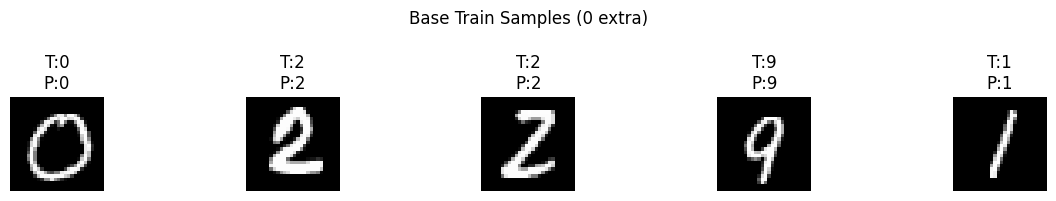

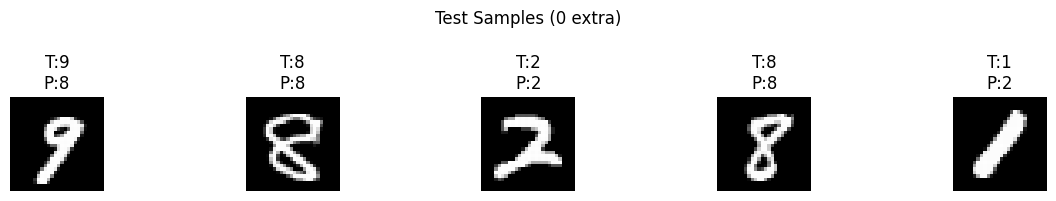

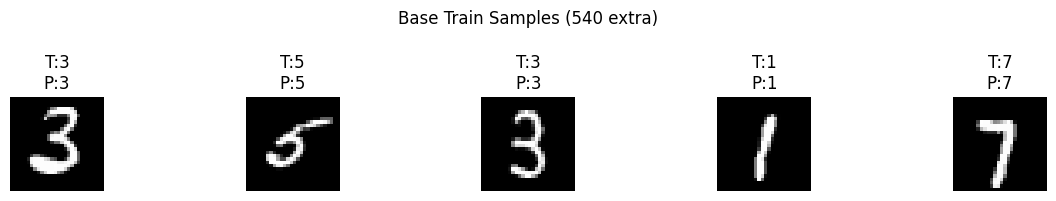

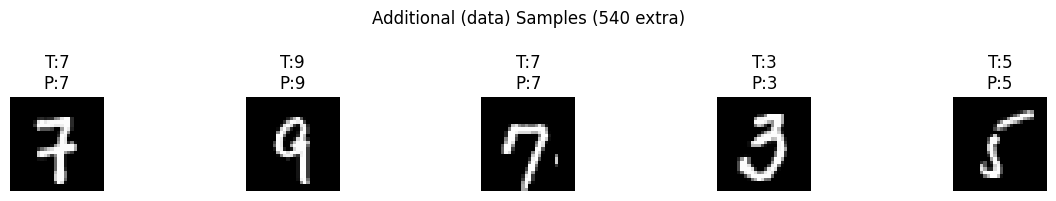

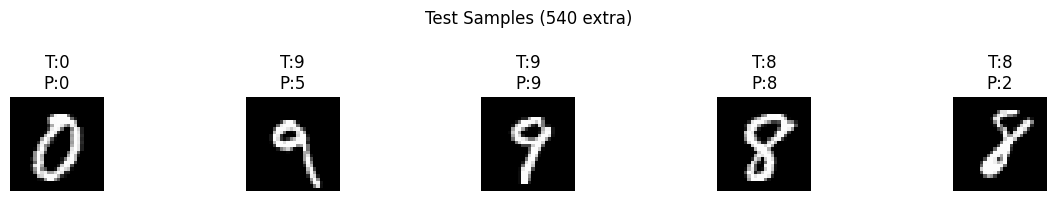

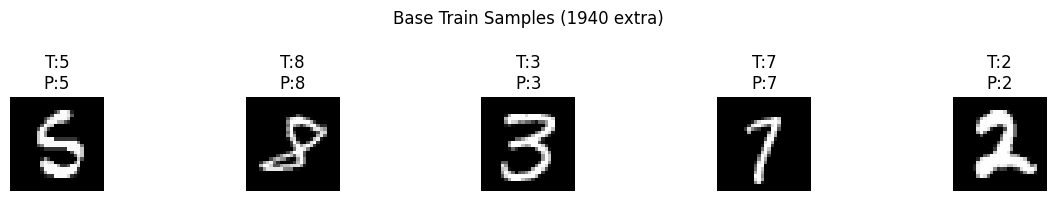

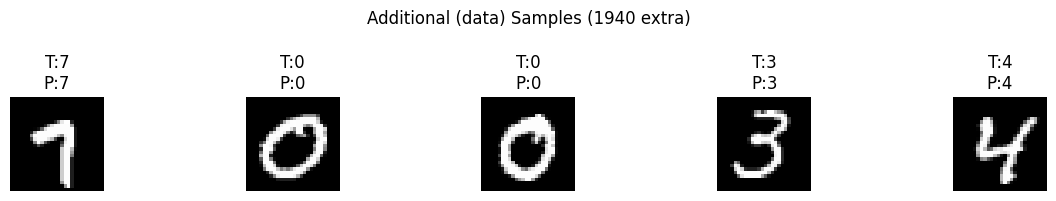

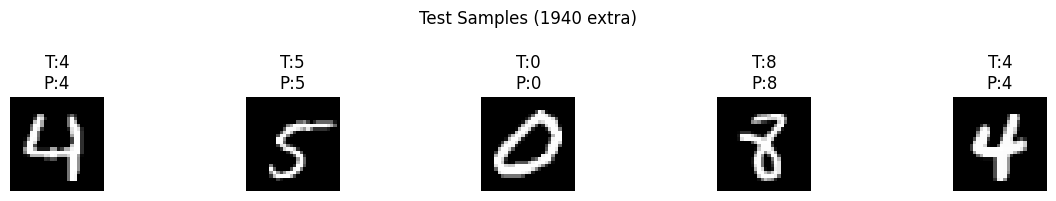

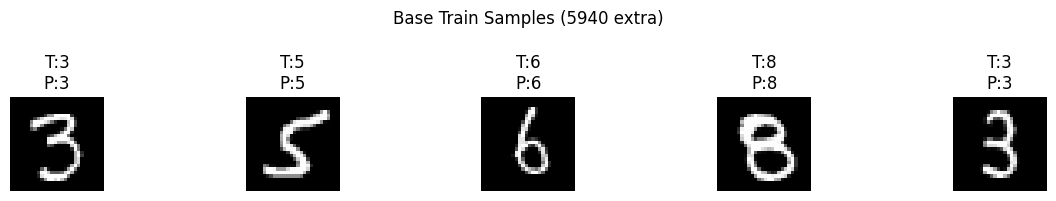

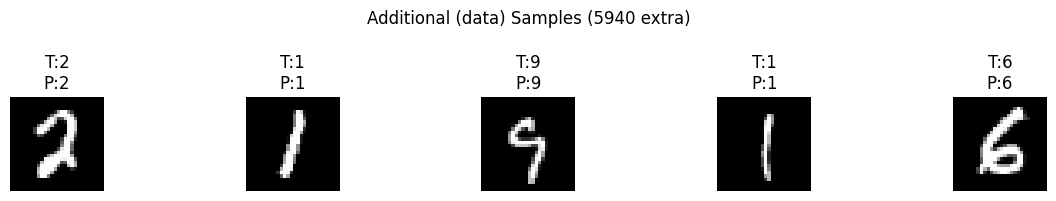

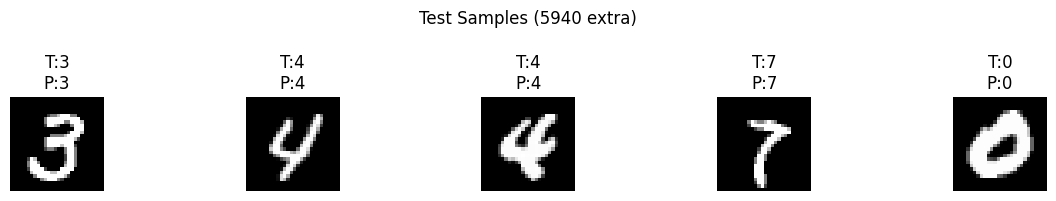

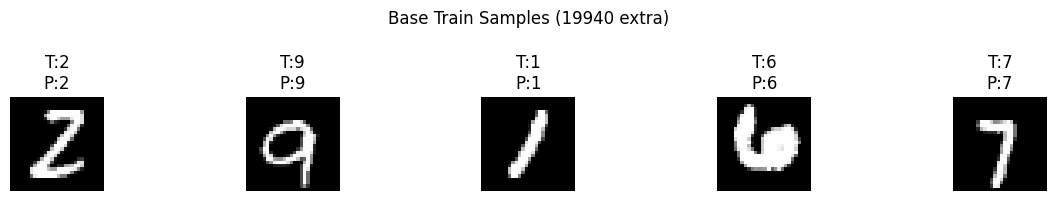

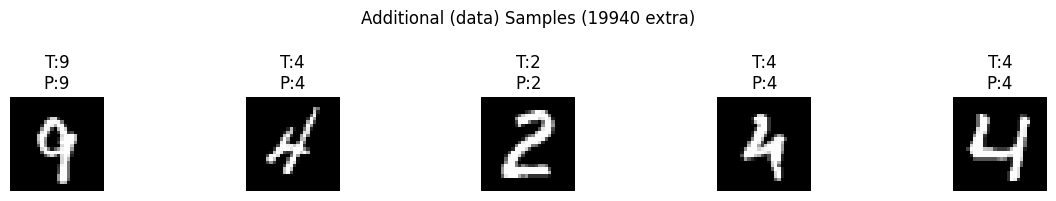

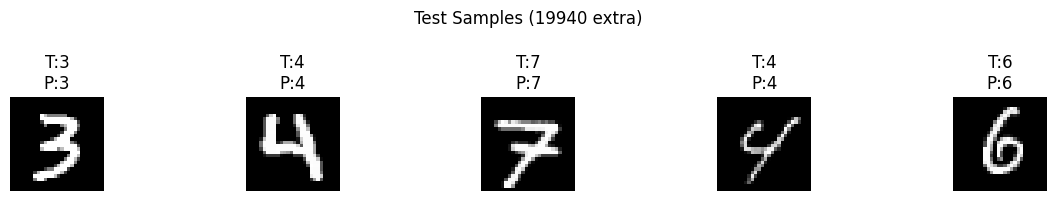

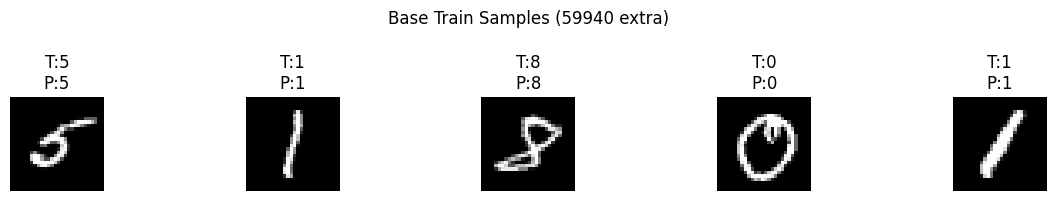

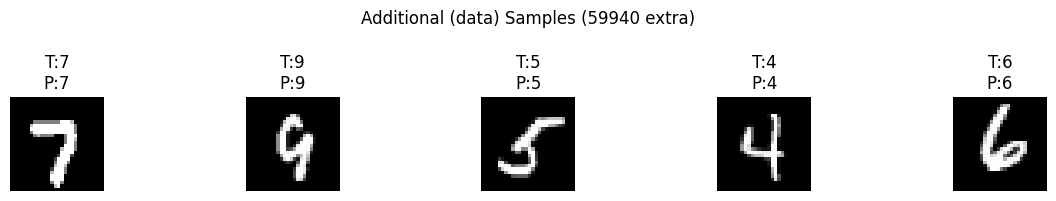

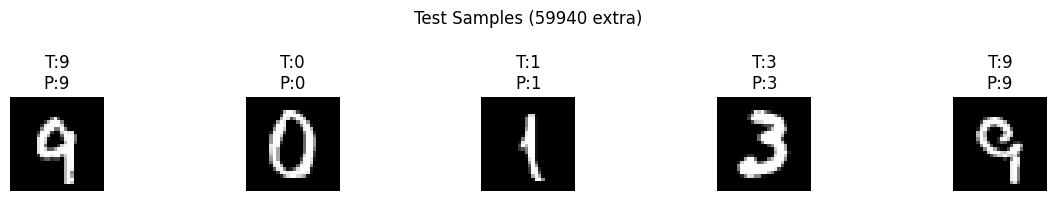

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_540.pt
Saved model: models_and_data/model_additional_540.pt
✅ Model saved to models_and_data\model_additional_1940.pt
Saved model: models_and_data/model_additional_1940.pt
✅ Model saved to models_and_data\model_additional_5940.pt
Saved model: models_and_data/model_additional_5940.pt
✅ Model saved to models_and_data\model_additional_19940.pt
Saved model: models_and_data/model_additional_19940.pt
✅ Model saved to models_and_data\model_additional_59940.pt
Saved model: models_and_data/model_additional_59940.pt
